# Import Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import re
import json
import time
import datetime
import math
import nltk
import string


from psaw import PushshiftAPI
import praw


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 

%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



import warnings
warnings.filterwarnings('ignore')

---

# Pre-processing text data

In [9]:
df_news_testext = pd.read_csv('/Users/mohammadiyliahaziq/Desktop/GA/dsi25-workspace/project_3/others/external_data_on_optimizied_model/For_LogReg/df_news.csv')
df_onion_testext = pd.read_csv('/Users/mohammadiyliahaziq/Desktop/GA/dsi25-workspace/project_3/others/external_data_on_optimizied_model/For_LogReg/df_onion.csv')
df_news_testext['subreddit'] = 1
df_onion_testext['subreddit'] = 0

df_combined = pd.concat((df_onion_testext.drop(columns=['Unnamed: 0','score','selftext','created_utc','num_comments']),
                        df_news_testext.drop(columns=['Unnamed: 0','score','selftext','created_utc','num_comments'])),
                        axis=0)

### Steps to pre-process text data:
1. remove punctuations
2. tokenize
3. remove stopwords
4. stem / lemmatize

In [115]:
stopword = nltk.corpus.stopwords.words('english')
puncts = string.punctuation
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

In [116]:
# function to clean text data so that it can be ready for modelling
def clean_text(text):
    # 1. remove punctuations
    title = ''.join([char for char in text if char not in puncts])
    # 2. tokenize
    my_list = re.split('\W+', title)
    my_list = list(filter(None, my_list))
    # 3. remove stop word
    my_list = [char.lower() for char in my_list if char.lower() not in stopword]
    # 4. lemmatize
    my_list = [wn.lemmatize(word) for word in my_list]
    
    return my_list

### Converting target variable subreddit into 0 and 1 binary form

In [117]:
df_combined['subreddit'].replace({'news':1,
                                 'TheOnion':0}, inplace=True)

# Vectorizing textual data using 3 methods, followed by modelling
1. CountVectorizer
    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
2. N-Grams
    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
3. TF-IDF
    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes

## Defining functions that will be used later on

In [118]:
# function to fit model into a chose classifier

def modelling(classifier):
    
    clf = classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = np.round(accuracy_score(y_test, y_pred),3)
    f1 = np.round(f1_score(y_test,y_pred),3)

    print("Accuracy: {}".format(accuracy))
    print("F1 score: {}".format(f1))

In [119]:
# function to plot heatmap with the current X_train, y_train, y_test, y_pred
# this will be used throughout

def plot_cm(title:str, clf):
    
    fig ,ax = plt.subplots(1,2, figsize=(10,5))
    fig.suptitle(("Confusion Matrix \n" + str(title)), fontsize=20)
    fig.tight_layout(pad = 3)

    sns.heatmap(
        confusion_matrix(y_train, clf.predict(X_train)),
        annot= True,
        square = True,
        linecolor= "Black",
        linewidths=1,
        ax=ax[0],
        fmt='g',
        cmap ='Blues',
        annot_kws={"size": 15},
        cbar=False

    )
    ax[0].set_title("Train Set", fontsize=15);
    ax[0].set_xticklabels(['r/TheOnion','news'], fontsize=10)
    ax[0].set_yticklabels(['r/TheOnion','news'], fontsize=10)


    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot= True,
        square = True,
        linecolor= "Black",
        linewidths=1,
        ax=ax[1],
        fmt='g',
        cmap ='BuGn',
        annot_kws={"size": 15},
        cbar=False
    )
    ax[1].set_title("Test Set", fontsize=15);
    ax[1].set_xticklabels(['r/TheOnion','news'], fontsize=10)
    ax[1].set_yticklabels(['r/TheOnion','news'], fontsize=10);


In [120]:
# function to plot barplot of vectorizing results

def plot_word_freq(X_counts, vectorizer, num_rows, name=""):
    '''
    vectorizer : count_vect or tfidf_vect
    name : name of vectorizer
    num_rows : num of rows to plot
    '''
    scale = num_rows/25
    # Converting ngram results into dataframe
    df = pd.DataFrame(X_counts.toarray())
    df.columns = vectorizer.get_feature_names()
    # adding up sum of occurences for each bigram words
    df_2 = pd.DataFrame(df.sum()).reset_index()
    df_2.columns =['word', 'frequency of occurence']
    # sorting bigram words in descending order
    df_2.sort_values(by='frequency of occurence', ascending=False, inplace=True)
    # plotting bar chart to visualise frequency of words
    x = df_2[df_2['frequency of occurence']>2]

    plt.figure(figsize=(14*(scale),8*(scale)))
    sns.barplot(df_2['frequency of occurence'][0:num_rows],df_2['word'][0:num_rows], orient='h')
    plt.xticks(rotation = 80);
    plt.title('Top ' + str(num_rows) + '\nwords with highest ' + str(name) + ' scores', fontsize=15);

In [121]:
# dataframe to keep track of the scores for the 3 methods of vectorizing words
df_score_comparison = pd.DataFrame(index = ['Accuracy score', 'F1-score']) 
# df_score_comparison.index = ['Accuracy score', 'F1-score']


___

# Hyperparameter Tuning
- From the above results, we see that the best score obtained was for Multinomial NB using CountVectorizer to vectorize the word text.
- Hence we proceed with hyperparameter tuning of Multinomial NB using Count Vectorizer / Bag of words

In [122]:
count_vect = CountVectorizer(analyzer=clean_text)
X_counts = count_vect.fit_transform(df_combined['title'])
print(X_counts.shape)

X_train, X_test, y_train, y_test = train_test_split(X_counts, df_combined['subreddit'], 
                                                    test_size=0.2, random_state=24)


clf = MultinomialNB()
clf = GridSearchCV(estimator=clf, param_grid={'alpha':[0.5,1,2,3,4,5], 'fit_prior':[True, False]},
                  verbose = 1, cv =5, return_train_score = False)

clf.fit(X_train, y_train)

(5000, 10731)
Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.5, 1, 2, 3, 4, 5],
                         'fit_prior': [True, False]},
             verbose=1)

- From the GridSearchCV, the score did not improve much from the default hyperparameters.
- The best parameters seem to be alpha =1 and fit_prior = False
- As the value of alpha refers to the amount of Laplace Smoothing, the optimal value of 1 seems to be right, considering the frequency of words occuring is in the region of 0-200. Too high alpha will result in very biased model as the model will rely too heavily on the alpha value instead of the actual probability of each word.
- The graph below shows how the accuracy score changes as we vary the alpha value

In [123]:
print(clf.best_score_)
print(clf.best_params_)

0.8772499999999999
{'alpha': 0.5, 'fit_prior': True}


- We apply the best parameters from GridSearchCV to our best model which was earlier found to be MultinomialNB
- We are able to attain a fairly high accuracy score of 0.89
- We also analyze the top words in r/news and r/TheOnion respectively below using GridSearchCV

In [124]:
# we apply the best parameters from GridSearchCV to our best model which was earlier found to be MultinomialNB
clf_gridsearch = MultinomialNB(alpha = 1, fit_prior=False)
clf_gridsearch.fit(X_train, y_train)
y_pred = clf_gridsearch.predict(X_test)
print(clf_gridsearch.score(X_train, y_train))
print(clf_gridsearch.score(X_test, y_test))

0.97225
0.893


___

# Testing our optimized model with additional external unseen data
- We attempt to use our model on more unseen datasets, webscraped from the 2 respective subreddits
- Top 1000 posts from r/news
- Top 1000 posts from r/TheOnion

In [13]:
df_news_testext = pd.read_csv('/Users/mohammadiyliahaziq/Desktop/GA/dsi25-workspace/project_3/others/external_data_on_optimizied_model/For_LogReg/df_news.csv')
df_onion_testext = pd.read_csv('/Users/mohammadiyliahaziq/Desktop/GA/dsi25-workspace/project_3/others/external_data_on_optimizied_model/For_LogReg/df_onion.csv')
df_news_testext['subreddit'] = 1
df_onion_testext['subreddit'] = 0

df_combined = pd.concat((df_onion_testext.drop(columns=['Unnamed: 0','score','selftext','created_utc','num_comments']),
                        df_news_testext.drop(columns=['Unnamed: 0','score','selftext','created_utc','num_comments'])),
                        axis=0)

df_combined = df_combined.sample(frac=1).reset_index(drop=True)

**Test our best model on the external datasets**

In [127]:
# count_vect has been optimized and fitted with training set data/vocab
# we just need to transform our external dataset onto the fitted count_vect
X_counts = count_vect.transform(df_combined['title'])
print(X_counts.shape)
X_test = X_counts
y_test = df_combined['subreddit']
print(y_test.shape)
y_pred = clf_gridsearch.predict(X_test)

(1000, 10731)
(1000,)


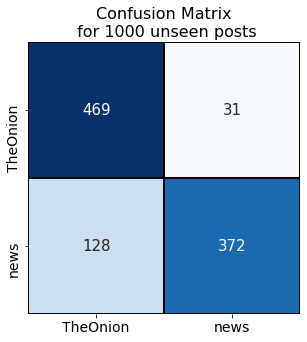

In [128]:
# plotting the score of our unseen data
accuracy_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,5))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot= True,
    square = True,
    linecolor= "Black",
    linewidths=1,
    fmt='g',
    cmap ='Blues',
    annot_kws={"size": 15},
    cbar=False,
    xticklabels=['TheOnion', 'news'],
    yticklabels=['TheOnion', 'news'],
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Confusion Matrix\n for 1000 unseen posts', fontsize=16);

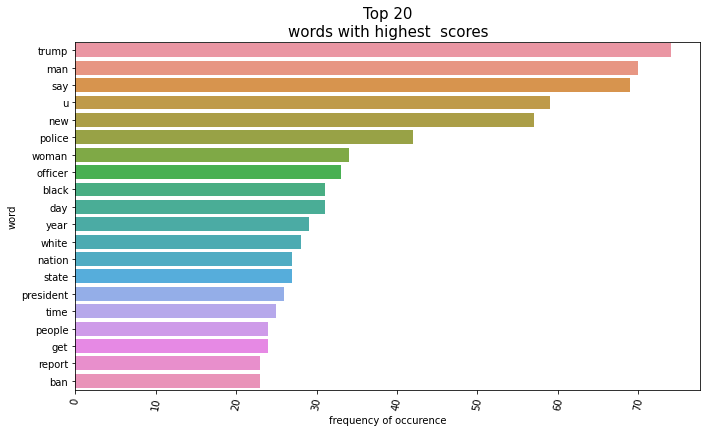

In [131]:
plot_word_freq(X_counts, count_vect, 20)

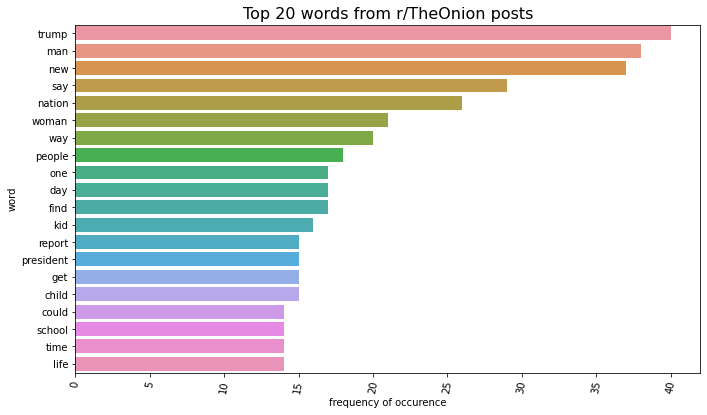

In [137]:
count_vect = CountVectorizer(analyzer=clean_text)
X_counts = count_vect.fit_transform(df_onion_testext['title'][0:500])
X_counts.shape

plot_word_freq(X_counts, count_vect, 20)
plt.title("Top 20 words from r/TheOnion posts", fontsize=16);

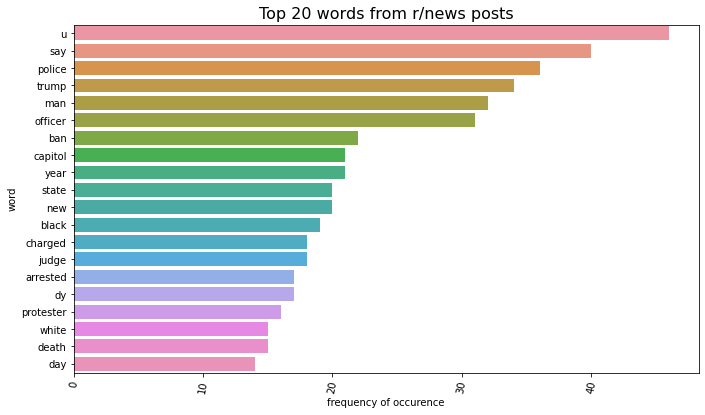

In [138]:
count_vect = CountVectorizer(analyzer=clean_text)
X_counts = count_vect.fit_transform(df_news_testext['title'][0:500])
X_counts.shape

plot_word_freq(X_counts, count_vect, 20)
plt.title("Top 20 words from r/news posts", fontsize=16);